## Random Forest

classification with many features 
continous varibale and label output 
When to use, how it fails, considerations 

Imagine we have a decision tree. Our decision tree is constructed by a greedy algorithim that chooses the best split point at each step, [this](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) is a great visualization on the mechanics of decision trees. 

Decision trees can suffer from high variance which makes their results fragile to the specific training data being used. 


If a decision tree has too much variance we can perform bagging, or bootstrapping- where we resample from the data to construct multiple trees. However if similar split points are chosen in each tree then we will not get the variance we are seeking. One way to force decision trees to be different is by limiting the features that the greedy algorithim can evaluate when creating a tree. This is the random forest algorithim. 

By limiting the number of features that can be considered for each split point, for instance considering only the square root of the total number of features we can construct trees that are different from each other resulting in predictions that are more diverse and a combined prediction that often has better performance than a single tree or bagging alone. 


A random forest begins with a standard machine learning technique called a decision tree. 




We can use bagging, building trees based on mulitple samples of the training data, can reduce this variance but the trees are highly correlated. 

A random forest is an extension of bagging where in additon to building trees based on multiple sampels of the training data it also constrains features that can be used to build the trees. 


### Procedure to construct tree

1. Load 
1. Choose a feature as a candidate for the split point. 
2. Calculate the gini index with that point. 

In [ ]:
# Select the best split point for a dataset
def get_split(dataset, n_features):
class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [16]:
%matplotlib inline 
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import numpy as np


# Load a CSV file
def load_csv(filename):
    # error somewhere hear
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold] # what is this shit about 
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Select the best split point for a dataset
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):     #here is where I am, I think visy around here
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
   # print('Here is the root %' % (root))
    print(root)
    return root

# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)

# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)

# Test the random forest algorithm
seed(2)
# load and prepare data
filename = 'sonar.all-data.csv'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(0, len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
for n_trees in [1, 5]:
    scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    print('Trees: %d' % (n_trees))
    print('Scores: %s' % (scores))
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

{'right': {'right': {'right': 0, 'value': 0.7409, 'index': 35, 'left': 0}, 'value': 0.7066, 'index': 16, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.576, 'index': 44, 'left': 1}, 'value': 0.0172, 'index': 53, 'left': {'right': {'right': 1, 'value': 0.4351, 'index': 18, 'left': 1}, 'value': 0.4901, 'index': 12, 'left': {'right': 1, 'value': 0.0576, 'index': 20, 'left': 1}}}, 'value': 0.1598, 'index': 39, 'left': {'right': 1, 'value': 0.2866, 'index': 33, 'left': 1}}, 'value': 0.4241, 'index': 42, 'left': {'right': {'right': {'right': 1, 'value': 0.0033, 'index': 51, 'left': 1}, 'value': 0.3317, 'index': 34, 'left': {'right': {'right': 1, 'value': 0.0466, 'index': 8, 'left': 1}, 'value': 0.1906, 'index': 33, 'left': 1}}, 'value': 0.0103, 'index': 54, 'left': {'right': 1, 'value': 0.0017, 'index': 1, 'left': 1}}}, 'value': 0.0669, 'index': 14, 'left': 0}}, 'value': 0.1952, 'index': 45, 'left': {'right': {'right': {'right': {'right': {'right': 0, 'value': 0.0163

{'right': {'right': {'right': {'right': 1, 'value': 0.9536, 'index': 33, 'left': 1}, 'value': 0.8726, 'index': 33, 'left': {'right': {'right': 0, 'value': 0.4858, 'index': 19, 'left': 0}, 'value': 0.0575, 'index': 1, 'left': {'right': {'right': 0, 'value': 0.8362, 'index': 29, 'left': 0}, 'value': 0.3599, 'index': 41, 'left': 0}}}, 'value': 0.6942, 'index': 33, 'left': {'right': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.0086, 'index': 49, 'left': 1}, 'value': 0.1916, 'index': 6, 'left': 1}, 'value': 0.1801, 'index': 5, 'left': 1}, 'value': 0.1711, 'index': 31, 'left': 0}, 'value': 0.8025, 'index': 17, 'left': {'right': {'right': 0, 'value': 0.1268, 'index': 13, 'left': 0}, 'value': 0.1896, 'index': 8, 'left': {'right': 0, 'value': 0.1437, 'index': 43, 'left': 0}}}, 'value': 0.9363, 'index': 19, 'left': {'right': {'right': {'right': {'right': 0, 'value': 0.0114, 'index': 48, 'left': 0}, 'value': 0.831, 'index': 29, 'left': {'right': {'right': 1, 'value': 0.1949, 'i

{'right': {'right': {'right': {'right': {'right': 1, 'value': 0.4012, 'index': 12, 'left': {'right': 0, 'value': 0.0823, 'index': 29, 'left': 0}}, 'value': 0.6086, 'index': 18, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.0232, 'index': 3, 'left': 1}, 'value': 0.4527, 'index': 41, 'left': 1}, 'value': 0.0092, 'index': 55, 'left': {'right': {'right': {'right': 1, 'value': 0.125, 'index': 5, 'left': 1}, 'value': 0.1729, 'index': 7, 'left': {'right': 1, 'value': 0.7337, 'index': 36, 'left': 1}}, 'value': 0.2095, 'index': 46, 'left': {'right': 1, 'value': 0.1375, 'index': 9, 'left': 1}}}, 'value': 0.1982, 'index': 44, 'left': 0}, 'value': 0.165, 'index': 12, 'left': {'right': 1, 'value': 0.1278, 'index': 1, 'left': {'right': {'right': 0, 'value': 0.24, 'index': 22, 'left': 0}, 'value': 0.0058, 'index': 50, 'left': {'right': 0, 'value': 0.0242, 'index': 2, 'left': 0}}}}}, 'value': 0.5142, 'index': 35, 'left': {'right': {'right': {'right': {'right': {'right': {'rig

{'right': {'right': {'right': {'right': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.1025, 'index': 30, 'left': 1}, 'value': 0.2562, 'index': 36, 'left': 1}, 'value': 0.2061, 'index': 6, 'left': {'right': {'right': {'right': 1, 'value': 0.0157, 'index': 58, 'left': 1}, 'value': 0.4241, 'index': 31, 'left': {'right': 1, 'value': 0.021, 'index': 53, 'left': 1}}, 'value': 0.6298, 'index': 21, 'left': {'right': 1, 'value': 0.0062, 'index': 54, 'left': 1}}}, 'value': 0.1124, 'index': 33, 'left': {'right': 1, 'value': 0.7236, 'index': 16, 'left': 1}}, 'value': 0.177, 'index': 12, 'left': 0}, 'value': 0.1874, 'index': 23, 'left': {'right': {'right': 1, 'value': 0.576, 'index': 20, 'left': 1}, 'value': 0.6632, 'index': 15, 'left': 0}}, 'value': 0.01, 'index': 57, 'left': {'right': {'right': {'right': {'right': 1, 'value': 0.7932, 'index': 19, 'left': {'right': 1, 'value': 0.0036, 'index': 59, 'left': {'right': 1, 'value': 0.6482, 'index': 29, 'left': 1}}}, 'value': 0.1364, '

{'right': {'right': {'right': 0, 'value': 0.9919, 'index': 34, 'left': {'right': 0, 'value': 0.0265, 'index': 52, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.1278, 'index': 44, 'left': 1}, 'value': 0.9376, 'index': 24, 'left': {'right': {'right': 1, 'value': 0.2945, 'index': 31, 'left': 1}, 'value': 0.6257, 'index': 29, 'left': {'right': 1, 'value': 0.2642, 'index': 40, 'left': 1}}}, 'value': 0.2843, 'index': 37, 'left': {'right': {'right': {'right': 1, 'value': 0.5364, 'index': 14, 'left': 1}, 'value': 0.0067, 'index': 59, 'left': {'right': 1, 'value': 0.749, 'index': 24, 'left': 1}}, 'value': 0.1331, 'index': 42, 'left': {'right': 1, 'value': 0.091, 'index': 44, 'left': 1}}}, 'value': 0.0026, 'index': 53, 'left': {'right': {'right': {'right': 1, 'value': 0.3309, 'index': 12, 'left': 1}, 'value': 0.8268, 'index': 21, 'left': 1}, 'value': 0.8959, 'index': 25, 'left': 0}}, 'value': 0.0041, 'index': 50, 'left': 0}}}, 'value': 0.8543, 'index': 26, 'left': {'rig

{'right': {'right': {'right': {'right': {'right': 0, 'value': 0.9819, 'index': 16, 'left': {'right': {'right': {'right': {'right': 1, 'value': 0.0947, 'index': 48, 'left': 1}, 'value': 0.4697, 'index': 41, 'left': {'right': 1, 'value': 0.188, 'index': 38, 'left': 1}}, 'value': 0.0932, 'index': 5, 'left': {'right': {'right': 1, 'value': 0.2188, 'index': 10, 'left': 1}, 'value': 0.4527, 'index': 41, 'left': {'right': 1, 'value': 0.3241, 'index': 18, 'left': {'right': 1, 'value': 0.0604, 'index': 2, 'left': 1}}}}, 'value': 0.5876, 'index': 30, 'left': {'right': {'right': {'right': {'right': 1, 'value': 0.8593, 'index': 19, 'left': 1}, 'value': 0.2758, 'index': 31, 'left': {'right': 1, 'value': 0.752, 'index': 27, 'left': 1}}, 'value': 0.0069, 'index': 1, 'left': {'right': 1, 'value': 0.0426, 'index': 39, 'left': 1}}, 'value': 0.1035, 'index': 42, 'left': {'right': 1, 'value': 0.0431, 'index': 33, 'left': 1}}}}, 'value': 0.1391, 'index': 43, 'left': {'right': {'right': {'right': 1, 'value'

{'right': {'right': {'right': {'right': {'right': 1, 'value': 0.023, 'index': 4, 'left': 1}, 'value': 0.2699, 'index': 36, 'left': {'right': {'right': {'right': {'right': 1, 'value': 0.8334, 'index': 26, 'left': 1}, 'value': 0.0759, 'index': 4, 'left': {'right': 1, 'value': 0.0252, 'index': 5, 'left': 1}}, 'value': 0.1929, 'index': 17, 'left': {'right': 1, 'value': 0.6553, 'index': 22, 'left': 1}}, 'value': 0.0151, 'index': 50, 'left': {'right': 1, 'value': 0.2429, 'index': 17, 'left': 1}}}, 'value': 0.7068, 'index': 28, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.0274, 'index': 51, 'left': 1}, 'value': 0.0185, 'index': 54, 'left': 1}, 'value': 0.2562, 'index': 36, 'left': {'right': {'right': 1, 'value': 0.0734, 'index': 45, 'left': 1}, 'value': 0.1276, 'index': 2, 'left': {'right': 1, 'value': 0.4186, 'index': 9, 'left': {'right': {'right': 1, 'value': 0.3391, 'index': 38, 'left': 1}, 'value': 0.9137, 'index': 14, 'left': {'right': 1, 'value': 1.0, 'index':

{'right': {'right': {'right': {'right': 0, 'value': 0.8299, 'index': 21, 'left': {'right': 1, 'value': 0.3523, 'index': 22, 'left': 1}}, 'value': 0.0145, 'index': 53, 'left': {'right': 0, 'value': 0.06, 'index': 3, 'left': 0}}, 'value': 0.1817, 'index': 5, 'left': {'right': {'right': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.6705, 'index': 34, 'left': 1}, 'value': 0.1057, 'index': 48, 'left': 1}, 'value': 0.2436, 'index': 16, 'left': 1}, 'value': 0.2316, 'index': 30, 'left': {'right': 0, 'value': 0.3082, 'index': 33, 'left': 0}}, 'value': 0.0188, 'index': 54, 'left': {'right': {'right': {'right': 1, 'value': 0.6295, 'index': 38, 'left': {'right': {'right': 1, 'value': 0.0054, 'index': 56, 'left': 1}, 'value': 0.2678, 'index': 17, 'left': {'right': 1, 'value': 1.0, 'index': 23, 'left': 1}}}, 'value': 0.3199, 'index': 9, 'left': {'right': {'right': {'right': 1, 'value': 0.1674, 'index': 40, 'left': 1}, 'value': 0.3775, 'index': 29, 'left': 1}, 'value': 0.0129, 'inde

{'right': {'right': {'right': {'right': 0, 'value': 0.0205, 'index': 49, 'left': 0}, 'value': 0.9919, 'index': 34, 'left': {'right': 0, 'value': 0.7733, 'index': 42, 'left': {'right': {'right': 0, 'value': 0.8995, 'index': 40, 'left': {'right': {'right': {'right': {'right': 1, 'value': 0.0252, 'index': 5, 'left': 1}, 'value': 0.0596, 'index': 4, 'left': {'right': 1, 'value': 0.185, 'index': 7, 'left': 1}}, 'value': 0.7766, 'index': 20, 'left': {'right': {'right': 1, 'value': 0.0177, 'index': 56, 'left': 1}, 'value': 0.3184, 'index': 20, 'left': {'right': 1, 'value': 0.9328, 'index': 28, 'left': 1}}}, 'value': 0.1082, 'index': 39, 'left': 0}}, 'value': 0.2375, 'index': 31, 'left': {'right': 0, 'value': 0.393, 'index': 37, 'left': 0}}}}, 'value': 0.0053, 'index': 51, 'left': {'right': 0, 'value': 0.0036, 'index': 52, 'left': 0}}, 'value': 0.1751, 'index': 45, 'left': {'right': {'right': {'right': {'right': {'right': {'right': 0, 'value': 0.0163, 'index': 59, 'left': 0}, 'value': 0.7213, 

{'right': {'right': {'right': {'right': {'right': 0, 'value': 1.0, 'index': 37, 'left': {'right': {'right': 1, 'value': 0.2854, 'index': 25, 'left': 1}, 'value': 0.4232, 'index': 45, 'left': {'right': {'right': {'right': 1, 'value': 0.434, 'index': 40, 'left': 1}, 'value': 0.5379, 'index': 43, 'left': {'right': 1, 'value': 0.7136, 'index': 22, 'left': 1}}, 'value': 0.9252, 'index': 26, 'left': {'right': 1, 'value': 0.2086, 'index': 24, 'left': 1}}}}, 'value': 0.4158, 'index': 28, 'left': 0}, 'value': 0.2694, 'index': 43, 'left': {'right': {'right': {'right': 0, 'value': 0.0999, 'index': 38, 'left': 0}, 'value': 0.0161, 'index': 57, 'left': {'right': {'right': {'right': 0, 'value': 0.5854, 'index': 22, 'left': 0}, 'value': 0.4713, 'index': 37, 'left': {'right': {'right': 0, 'value': 0.2707, 'index': 10, 'left': 0}, 'value': 0.214, 'index': 6, 'left': {'right': {'right': 0, 'value': 0.3966, 'index': 40, 'left': 0}, 'value': 0.0078, 'index': 56, 'left': {'right': 0, 'value': 0.243, 'index

{'right': {'right': {'right': {'right': 0, 'value': 0.0205, 'index': 3, 'left': 0}, 'value': 0.5334, 'index': 25, 'left': {'right': 0, 'value': 0.0075, 'index': 8, 'left': 0}}, 'value': 0.6096, 'index': 40, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.0087, 'index': 55, 'left': {'right': 0, 'value': 0.9664, 'index': 22, 'left': {'right': 0, 'value': 0.2195, 'index': 45, 'left': 0}}}, 'value': 0.8825, 'index': 21, 'left': {'right': {'right': 1, 'value': 0.1125, 'index': 5, 'left': 1}, 'value': 0.1125, 'index': 5, 'left': 0}}, 'value': 0.1627, 'index': 6, 'left': {'right': {'right': {'right': 1, 'value': 0.0249, 'index': 55, 'left': {'right': {'right': 1, 'value': 0.8543, 'index': 26, 'left': 1}, 'value': 0.0271, 'index': 50, 'left': 1}}, 'value': 0.6034, 'index': 39, 'left': {'right': {'right': 1, 'value': 0.2592, 'index': 8, 'left': {'right': 1, 'value': 0.2462, 'index': 8, 'left': 1}}, 'value': 0.1054, 'index': 48, 'left': {'right': {'right': 1, 'value': 0.0

{'right': {'right': {'right': {'right': {'right': 0, 'value': 0.522, 'index': 40, 'left': 0}, 'value': 0.805, 'index': 33, 'left': {'right': {'right': {'right': 1, 'value': 0.1483, 'index': 41, 'left': 1}, 'value': 0.7924, 'index': 14, 'left': {'right': {'right': {'right': {'right': 1, 'value': 0.8917, 'index': 26, 'left': 1}, 'value': 0.9395, 'index': 25, 'left': {'right': 1, 'value': 0.2263, 'index': 6, 'left': 1}}, 'value': 0.1256, 'index': 5, 'left': {'right': {'right': 1, 'value': 0.0087, 'index': 54, 'left': 1}, 'value': 0.2408, 'index': 37, 'left': 1}}, 'value': 0.0341, 'index': 2, 'left': {'right': {'right': 1, 'value': 0.0241, 'index': 53, 'left': 1}, 'value': 1.0, 'index': 21, 'left': {'right': {'right': 1, 'value': 0.484, 'index': 39, 'left': 1}, 'value': 0.1075, 'index': 4, 'left': {'right': 1, 'value': 0.0104, 'index': 53, 'left': 1}}}}}, 'value': 0.0118, 'index': 51, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.0104, 'index': 53, 'left': 1}, 'va

{'right': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.7236, 'index': 16, 'left': {'right': 1, 'value': 0.143, 'index': 14, 'left': 1}}, 'value': 0.1464, 'index': 43, 'left': {'right': 1, 'value': 0.12, 'index': 39, 'left': 1}}, 'value': 0.9896, 'index': 26, 'left': {'right': {'right': {'right': 1, 'value': 0.0376, 'index': 3, 'left': 1}, 'value': 0.7326, 'index': 17, 'left': 1}, 'value': 1.0, 'index': 21, 'left': {'right': {'right': {'right': {'right': {'right': 1, 'value': 0.096, 'index': 47, 'left': 1}, 'value': 0.1256, 'index': 5, 'left': {'right': 1, 'value': 0.0046, 'index': 55, 'left': 1}}, 'value': 0.096, 'index': 47, 'left': {'right': {'right': 1, 'value': 0.0116, 'index': 56, 'left': 1}, 'value': 0.5196, 'index': 14, 'left': {'right': 1, 'value': 0.1142, 'index': 39, 'left': 1}}}, 'value': 0.0809, 'index': 34, 'left': {'right': 1, 'value': 0.3244, 'index': 33, 'left': 1}}, 'value': 0.2122, 'index': 9, 'left': {'right': {'right': 1, 'value': 0.0214, 'index':

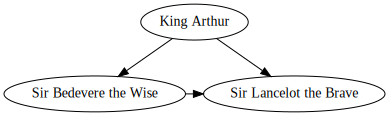

In [4]:
from graphviz import Digraph

dot = Digraph(comment='The Round Table')

dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

dot

A random forest, like a decision tree can use quantitiative or categorical data for both the target and the features. 

Random forests generalize well and small changes in the data do not change the results. The downside to forest are that they are not actually interpretted. Instead a random forest is used to rank the features that are most important. 

plot the accuracy versus the number of trees 
and the importance scores for features 

decision trees are easy to visualize and can reveal patterns 
in our data that would not be found in traditional forms of 
regression
